# Import libraries


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)
import pandas as pd
import h5py
import math

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', size=16)
import pickle
from sklearn.model_selection import train_test_split

2.15.0


# Data Preprocessing


Number of electron samples:  249000
Number of photon samples:  249000


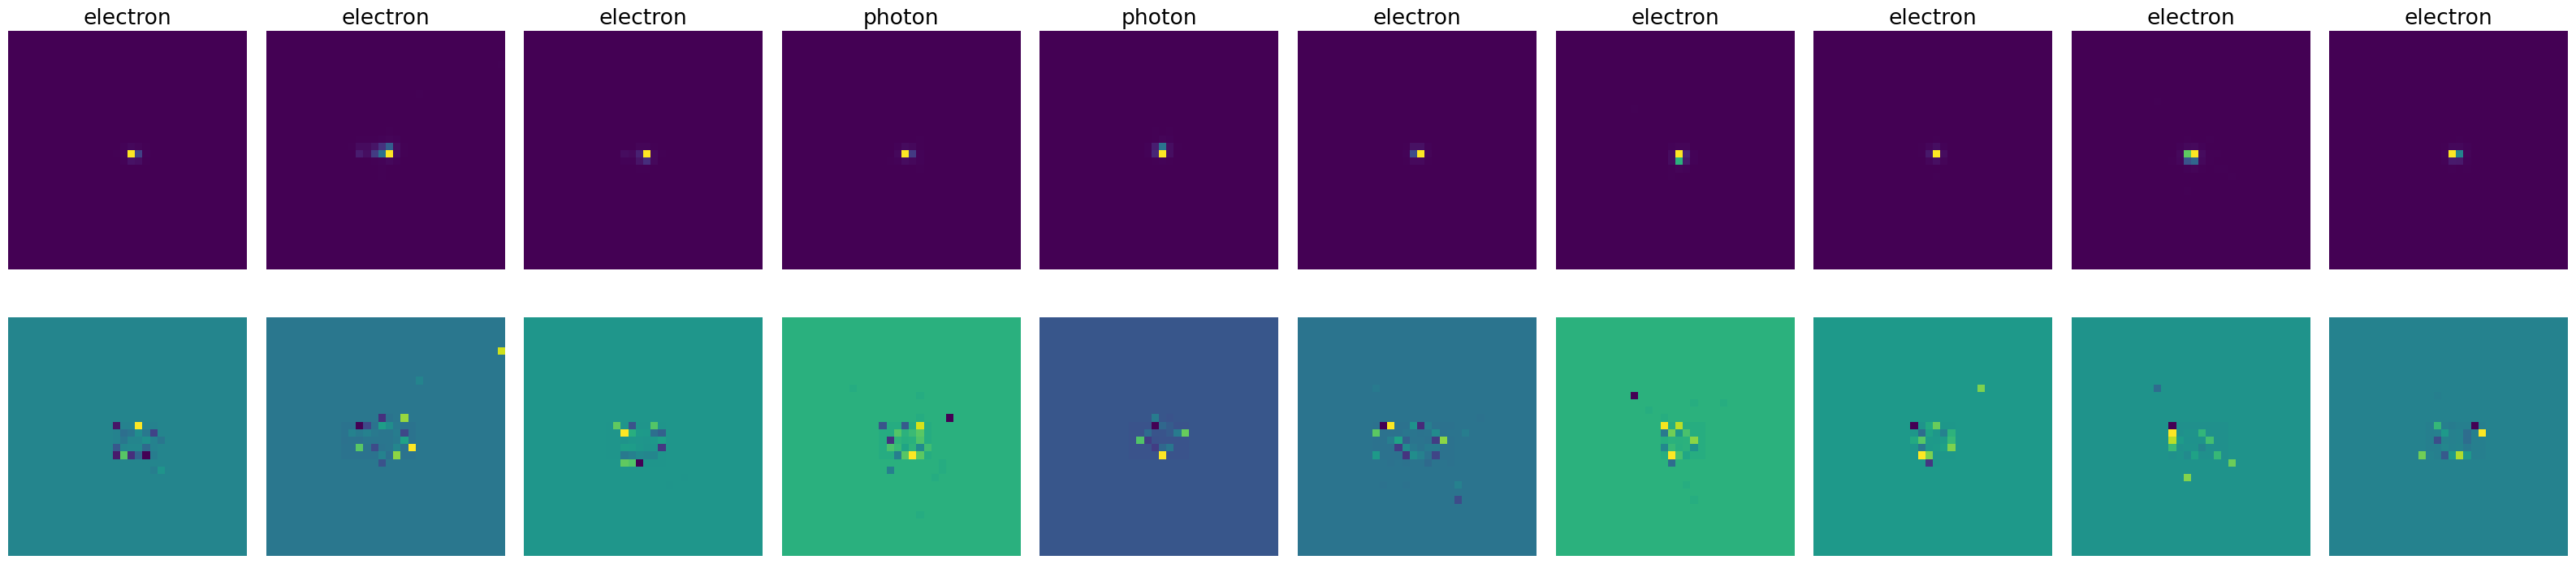

Training Data Shape: (398400, 32, 32, 2)
Training Label Shape: (398400,)
Validation Data Shape: (79680, 32, 32, 2)
Validation Label Shape: (79680,)
Test Data Shape: (19920, 32, 32, 2)
Test Label Shape: (19920,)


In [ ]:
# Import dataset

# Importing electron dataset
electron_dataset = h5py.File("SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5","r")
electron_imgs=np.array(electron_dataset["X"])
electron_labels=np.array(electron_dataset["y"],dtype=np.int64)

# Importing photon dataset
photon_dataset = h5py.File("SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5","r")
photon_imgs=np.array(photon_dataset["X"])
photon_labels=np.array(photon_dataset["y"],dtype=np.int64)

# Classes are balanced
print('Number of electron samples: ', len(electron_labels))
print('Number of photon samples: ', len(photon_labels))

# Concatenate electron and photon images/labels
img_arrs = np.vstack((photon_imgs,electron_imgs))
labels = np.hstack((photon_labels,electron_labels)).astype(np.int64)

del electron_dataset
del electron_imgs
del electron_labels
del photon_dataset
del photon_imgs
del photon_labels

bin2lab = {0:'electron',
           1: 'photon'}

# Display a sample of images from the training-validation dataset
# Each sample is made up of two channels
num_img = 10
idxs = np.random.randint(0, len(labels), size=(num_img,))
fig, axes = plt.subplots(2, num_img, figsize=(32, 8))

# Iterate through the selected number of samples
for i in range(num_img):
    ax0 = axes[0][i]
    ax0.imshow(img_arrs[idxs[i]][:,:,0])
    ax0.axis('off')

    ax1 = axes[1][i]
    ax1.imshow(img_arrs[idxs[i]][:,:,1])
    ax1.axis('off')

    ax0.set_title('{}'.format(bin2lab[labels[idxs[i]]]))


# Adjust layout and display the images
plt.tight_layout()
plt.show()

# split the data in training and validation set
split_valid = 0.2
X_train,X_val,y_train,y_val = train_test_split(img_arrs,labels, random_state=seed, test_size=split_valid, stratify=labels)
X_val,X_test,y_val,y_test = train_test_split(X_val,y_val, random_state=seed, test_size=split_valid, stratify=y_val)

del img_arrs
del labels

# Print the shapes of the datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

In [ ]:
# Calculate channel-wise mean and standard deviation of training data
meanScaling=True
if meanScaling:
    mean_train = np.mean(X_train, axis=(0, 1, 2))
    std_train = np.std(X_train, axis=(0, 1, 2))

    mean_train, std_train

    # Normalize each channel independently
    X_train = (X_train - mean_train) / std_train
    X_val = (X_val - mean_train) / std_train
else:
    min_train = np.min(X_train, axis=(0,1,2))
    max_train = np.max(X_train, axis=(0,1,2))

    a = (min_train +max_train)/2
    b = (max_train-min_train)/2
    X_train = (X_train - a) / (b)
    X_val = (X_val - a) / (b)

In [ ]:
#np.save('mean_train.npy', mean_train)
#np.save('std_train.npy', std_train)

# ResNet Model


The ResNet model has been implemented as in the original paper https://arxiv.org/pdf/1512.03385.pdf with only one main difference. The spatial dimensions are reduced with MaxPooling2D layers outside the ResNet block instead of strided convolutions. The skip connections perform a convolution with kernel size (1,1) to match the number of filters in output of each ResNet block. A batch normalization layer is applied after every convolution. The head of the network is a GAP layer that gives a 512 sized vector that after a dropout layer is used to compute with a dense layer the only output neuron.

The network has been trained minimizing a binary crossentropy loss with Adam optimizer with a cosine learning rate scheduler. Early stopping has been used to prevent overfitting.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net (ResNet)            (4, 7, 7, 512)            1677144   
                                                                 
 global_average_pooling2d (  (4, 512)                  0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_5 (Dropout)         (4, 512)                  0         
                                                                 
 dense (Dense)               (4, 256)                  131328    
                                                                 
 dropout_6 (Dropout)         (4, 256)                  0         
                                                                 
 dense_1 (Dense)             (4, 1)                    257       
                                                      

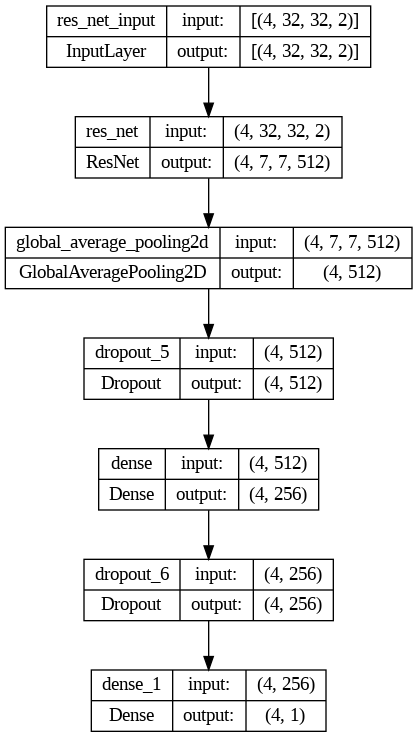

In [ ]:
class ResNetBlock(tfkl.Layer):
    def __init__(self, filters1, filters2, downsample=True, use_batch_norm=True, activation='relu', **kwargs):
        super(ResNetBlock, self).__init__(**kwargs)

        self.use_batch_norm = use_batch_norm
        self.activation = activation
        self.downsample = downsample

        # ConvLayer1
        self.conv1 = tfkl.Conv2D(filters1, kernel_size=1, strides=1, padding='same')

        # BatchNorm1
        if use_batch_norm:
            self.bn1 = tfkl.BatchNormalization()
        self.activation1 = tfkl.ReLU() if activation == 'relu' else tf.keras.layers.Activation(activation)

        # ConvLayer2
        self.conv2 = tfkl.Conv2D(filters1, kernel_size=3, padding='same')

        # BatchNorm2
        if use_batch_norm:
            self.bn2 = tfkl.BatchNormalization()
        self.activation2 = tfkl.ReLU() if activation == 'relu' else tf.keras.layers.Activation(activation)

        # ConvLayer3
        self.conv3 = tfkl.Conv2D(filters2, kernel_size=1, padding='same')

        # BatchNorm3
        if use_batch_norm:
            self.bn3 = tfkl.BatchNormalization()

        # Shortcut connection
        if self.downsample:
            self.conv4 = tfkl.Conv2D(filters2, kernel_size=1, strides=1, activation='relu',padding='same')
            self.bn4 = tfkl.BatchNormalization()
        self.shortcut = tfkl.Add()
        self.activation3 = tfkl.ReLU() if activation == 'relu' else tf.keras.layers.Activation(activation)

    def call(self, inputs, training=None, **kwargs):
        x = self.conv1(inputs)
        if self.use_batch_norm:
            x = self.bn1(x, training=training)
        x = self.activation1(x)

        x = self.conv2(x)
        if self.use_batch_norm:
            x = self.bn2(x, training=training)
        x = self.activation2(x)

        x = self.conv3(x)
        if self.use_batch_norm:
            x = self.bn3(x, training=training)

        if self.downsample:
            inputs = self.conv4(inputs)
            inputs = self.bn4(inputs)

        shortcut = self.shortcut([inputs, x])
        return self.activation3(shortcut)

class ResNet(tfk.Model):
  def __init__(self,**kwargs):
    super().__init__(**kwargs)

    blocks = [
        tfkl.Conv2D(8,3,activation='relu'),
        tfkl.Dropout(0.1),
        ResNetBlock(16,64,downsample=True,use_batch_norm=True, activation='relu'),
        ResNetBlock(16,64,downsample=True,use_batch_norm=True, activation='relu'),
        tfkl.MaxPool2D(),
        tfkl.Dropout(0.1),
        ResNetBlock(32,128,downsample=True,use_batch_norm=True, activation='relu'),
        ResNetBlock(32,128,downsample=True,use_batch_norm=True, activation='relu'),
        tfkl.MaxPool2D(),
        tfkl.Dropout(0.1),
        ResNetBlock(64,256,downsample=True,use_batch_norm=True, activation='relu'),
        tfkl.Dropout(0.1),
        ResNetBlock(128,512,downsample=True,use_batch_norm=True, activation='relu'),
        tfkl.Dropout(0.1),
        ResNetBlock(256,512,downsample=True,use_batch_norm=True, activation='relu'),
    ]

    self.network = tfk.Sequential(blocks)

  def call(self,x):
    x = self.network(x)
    return x

augmentation = tfk.Sequential([
    tfkl.RandomTranslation(0.1,0.1)
])

ResNet_model = tfk.Sequential([
    #augmentation,
    ResNet(),
    tfkl.GlobalAveragePooling2D(),
    tfkl.Dropout(0.1),
    tfkl.Dense(256,activation='relu'),
    tfkl.Dropout(0.1),
    tfkl.Dense(1,activation='sigmoid')
])

ResNet_model(X_train[:4])
ResNet_model.summary()
tfk.utils.plot_model(ResNet_model, expand_nested=True, show_shapes=True)

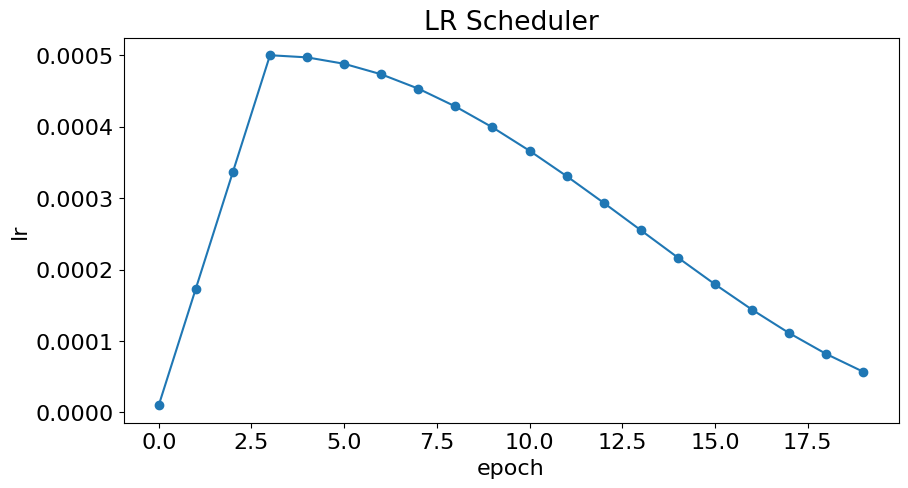

In [ ]:
batch_size = 256
epochs = 20

def get_lr_callback(batch_size=32, mode='cos', epochs=50, plot=False):
    lr_start, lr_max, lr_min = 1e-5, 5e-4, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return tfk.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

lr_cb = get_lr_callback(batch_size, mode='cos', epochs=epochs, plot=True)
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)
callbacks = [early_stopping, lr_cb]

In [ ]:
# Define optimizer and metrics
learning_rate = 1e-5
optimizer = tfk.optimizers.Adam(learning_rate)
loss = tfk.losses.BinaryCrossentropy()
metrics = ["accuracy",'AUC']

# Compile the model
ResNet_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Train the model
history = ResNet_model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/20
1557/1557 [==============================] - 265s 154ms/step - loss: 0.6840 - accuracy: 0.5564 - auc: 0.5804 - val_loss: 0.6715 - val_accuracy: 0.5863 - val_auc: 0.6246 - lr: 1.0000e-05
Epoch 2/20
1557/1557 [==============================] - 230s 148ms/step - loss: 0.6626 - accuracy: 0.5999 - auc: 0.6350 - val_loss: 0.6533 - val_accuracy: 0.6192 - val_auc: 0.6627 - lr: 1.7333e-04
Epoch 3/20
1557/1557 [==============================] - 231s 148ms/step - loss: 0.6475 - accuracy: 0.6230 - auc: 0.6660 - val_loss: 0.6381 - val_accuracy: 0.6402 - val_auc: 0.6902 - lr: 3.3667e-04
Epoch 4/20
1557/1557 [==============================] - 231s 148ms/step - loss: 0.6274 - accuracy: 0.6511 - auc: 0.7011 - val_loss: 0.6044 - val_accuracy: 0.6754 - val_auc: 0.7347 - lr: 5.0000e-04
Epoch 5/20
1557/1557 [==============================] - 231s 149ms/step - loss: 0.5938 - accuracy: 0.6893 - auc: 0.7472 - val_loss: 0.5792 - val_accuracy: 0.7008 - val_auc: 0.7687 - lr: 4.9698e-04
Epoch 6/20
1557

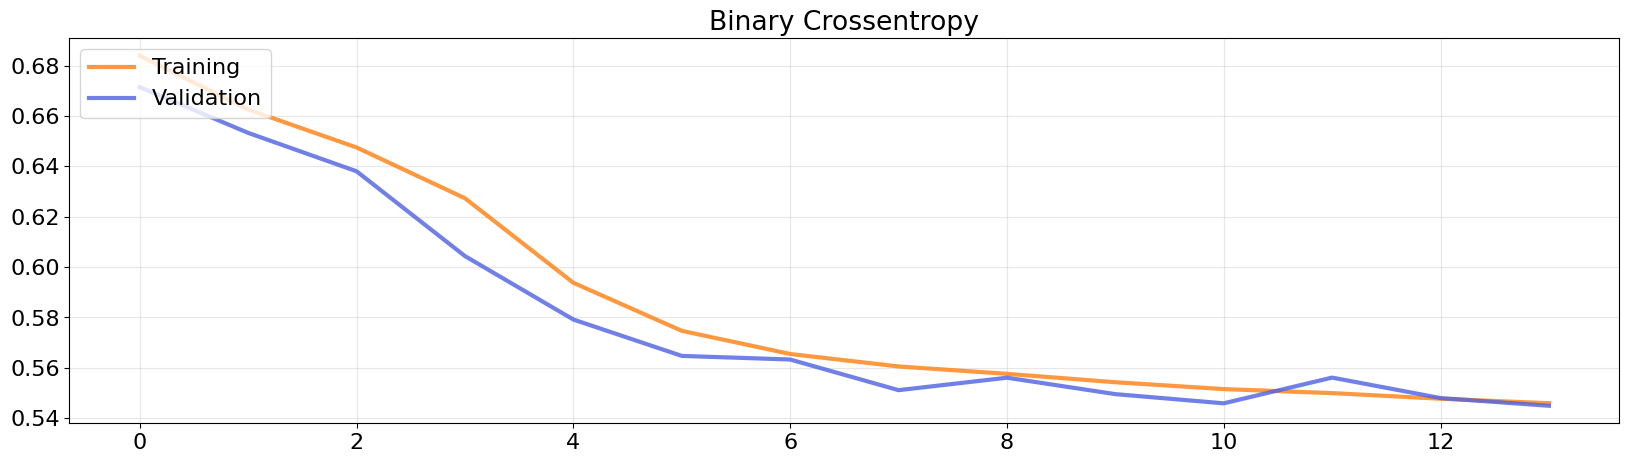

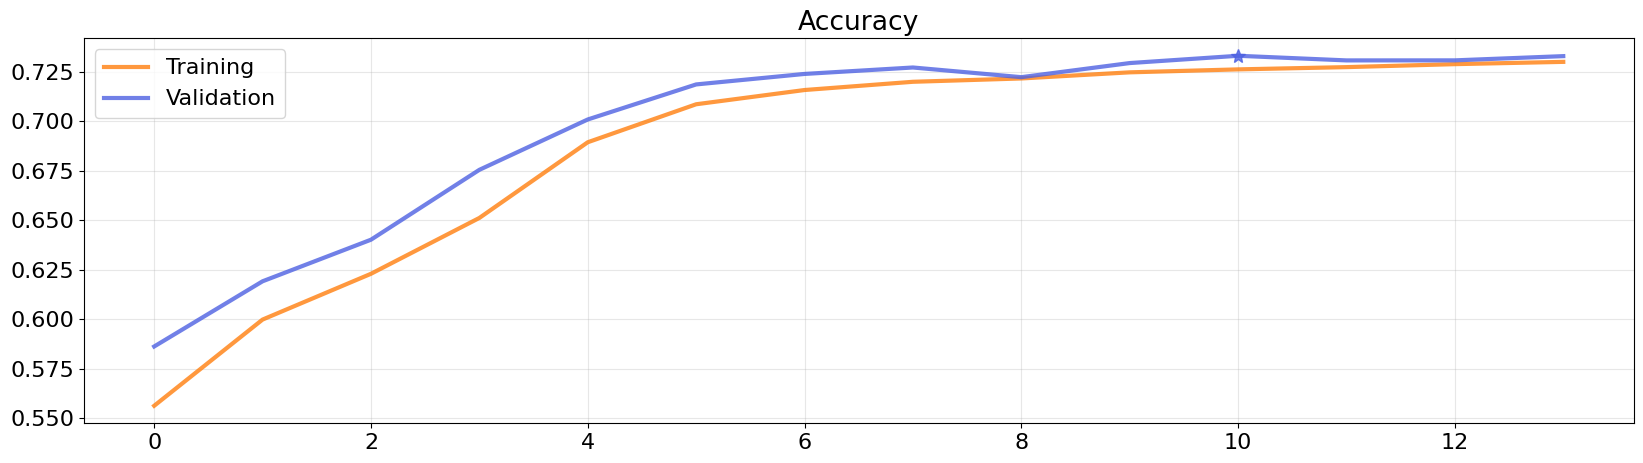

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
X_test = (X_test - mean_train) / std_train

In [ ]:
ResNet_model.evaluate(X_test,y_test)

623/623 [==============================] - 7s 9ms/step - loss: 0.5444 - accuracy: 0.7308 - auc: 0.8012


[0.5443878769874573, 0.730823278427124, 0.8011894822120667]

In [ ]:
save = False

if save:
  ResNet_model.save('resnet')

In [ ]:
del ResNet_model
del history